<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeAutomatizado/blob/2022-2/notebooks/2b_regularizacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresión lineal con penalización por norma $\ell_1$ y $\ell_2$

Primero importarmos las bibliotecas necesarias:

In [1]:
import numpy as np
import scipy.sparse as sp
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

## Conjunto de datos
Posteriormente generamos nuestro conjunto de datos (basado en ejemplo de [PMTK3](https://github.com/probml/pmtk3).

In [2]:
X_ent = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,
               11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0])
y_ent = np.array([3.10341864, -0.36949342, -4.20684311, -5.61381536,
                    -4.09482862, -3.23548442, -2.12902581, -7.28955698,
                    -2.8821206, -8.44323436, -5.9491123, -4.77948529,
                    -2.34705651, -3.11360479, 0.58915552, 3.66236699,
                    3.14385906, 11.92541392, 12.06829608, 13.37635698, 14.84302011])
n_ent = X_ent.shape[0]

X_valid = np.array([2.2, 2.7, 8.6, 9.5, 10.4, 10.5, 11.4, 14.9, 17.4, 19.3])
y_valid = np.array([-4.87830149, -2.22417664, -4.78937076, -5.39555669,
                    -1.89941084, -4.39873376, -2.74141712, 0.86251019,
                    8.2396395, 13.25506972])
n_valid = X_valid.shape[0]

X_rango = np.linspace(0, 20, 10000) # para graficar

Graficamos nuestros datos

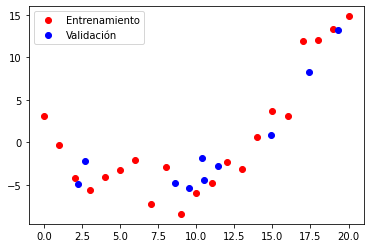

In [3]:
train_plot = plt.plot(X_ent, y_ent, 'ro', label = 'Entrenamiento')
valid_plot = plt.plot(X_valid, y_valid, 'bo', label = u'Validación')
plt.legend()
plt.show()

## Expansión polinomial
Definimos la función de expansión polinomial, la cual toma un vector de atributos y calcula cada grado del polinomio con él.

In [4]:
def expol(X, grado):
  phi_X = X
  for i in range(grado - 1):
    powerX = np.power(X, i + 2)
    phi_X = np.column_stack((phi_X, powerX))
    
  unos = np.ones(phi_X.shape[0])
  return np.column_stack((unos, phi_X))

## Suma de errores cuadráticos
También definimos la función de errores cuadráticos


In [5]:
def sse(y, y_hat):
  return np.square(y - y_hat).sum()

## Mínimos cuadrados
Clase base para regresión lineal al estilo scikit-learn, en la cual se definen únicamente los métodos `fit` y `predict`

In [6]:
class RegresionLineal():
  def fit(self, X, y):
    '''
    Estima los parámetros del modelo
    '''
    self._estima_parametros(X, y)
  
  def predict(self, X):
    '''
    Predice valores de vectores dados
    '''
    return X @ self.parameters

Generamos una clase hija donde se define el método (`_estima_parametros`) con la solución de mínimos cuadrados
$$
\boldsymbol{\theta}_{EMV} = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y}
$$

In [7]:
class MinimosCuadrados(RegresionLineal):
  def _estima_parametros(self, X, y):
    self.parameters = np.linalg.inv(X.T @ X) @ (X.T @ y)

Definimos función que entrena y evalúa modelos de regresión dados los datos

In [8]:
def entrena_evalua(m, X_ent, y_ent, X_valid, y_valid, X_rango, grado):
  phi_X_ent = expol(X_ent, grado)
  phi_X_valid = expol(X_valid, grado)

  m.fit(phi_X_ent, y_ent)

  y_hat_ent = m.predict(phi_X_ent)
  y_hat_valid = m.predict(phi_X_valid)

  phi_X_rango = expol(X_rango, grado)
  y_hat_rango = m.predict(phi_X_rango)

  mse_ent = sse(y_ent, y_hat_ent) / n_ent
  mse_valid = sse(y_valid, y_hat_valid) / n_valid

  return y_hat_rango, mse_ent, mse_valid

Aplicamos expansión polinomial con diferentes grados a la entrada, ajustamos un modelo para cada expansión y evaluamos su rendimiento

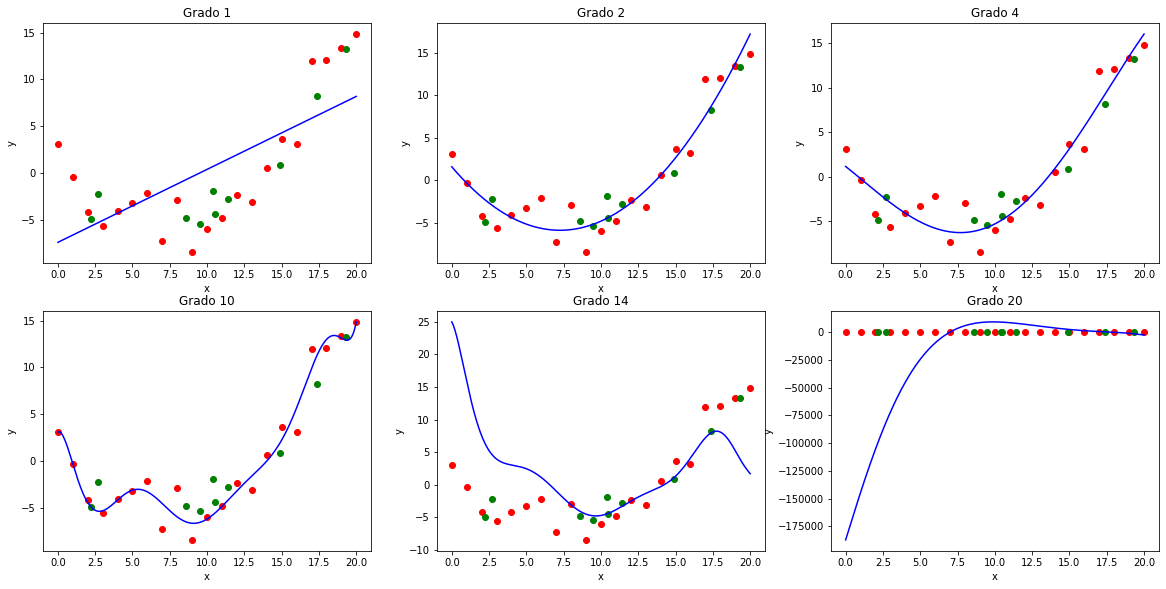

In [9]:
grados = np.array([1,2,4,10,14, 20])
mse_ent_grados = np.zeros(grados.shape[0])
mse_valid_grados = np.zeros(grados.shape[0])
plt.figure(figsize=(20,15))
for i,g in enumerate(grados):
  plt.subplot(3, 3, i + 1)
  y_hat_rango, mse_ent_grados[i], mse_valid_grados[i] = entrena_evalua(MinimosCuadrados(), 
                                                                       X_ent, y_ent,
                                                                       X_valid, y_valid,
                                                                       X_rango, g)
  plt.plot(X_ent, y_ent, 'ro', label='Datos de entrenamiento')
  plt.plot(X_valid, y_valid, 'go', label='Datos de validación')
  plt.plot(X_rango, y_hat_rango, 'b', label='Modelo ajustado')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title('Grado ' + str(g))
plt.show()

### Por descomposición QR
¿Qué pasa cuando expandimos el polinomio en grado 20? La solución de mínimos cuadrados se vuelve numéricamente inestable. 

Afortunadamente, podemos calcular esta solución de una forma más estable usando la descomposición QR y evitando realizar el cómputo de $(\mathbf{X}^\top \mathbf{X})^{-1}$. 

$$
\mathbf{X} = \mathbf{Q} \mathbf{R}, \text{ donde } \mathbf{Q}^\top \mathbf{Q} =  \mathbf{Q} \mathbf{Q}^\top = \mathbf{I}
$$

Substituyendo en la solución de mínimos cuadrados y aplicando propiedades de transpuestas e inversas

$$
\begin{align}
\boldsymbol{\theta}_{EMV} = & \left[\underbrace{(\mathbf{Q} \mathbf{R})^\top}_{\mathbf{R}^\top \mathbf{Q}^\top} (\mathbf{Q}\mathbf{R})\right]^{-1} \underbrace{(\mathbf{Q} \mathbf{R})^\top}_{\mathbf{R}^\top \mathbf{Q}^\top} \mathbf{y} \\ 
= & \left[\mathbf{R}^\top \underbrace{\mathbf{Q}^\top \mathbf{Q}}_{\mathbf{I}} \mathbf{R}\right]^{-1} \mathbf{R}^\top \mathbf{Q}^\top \mathbf{y} \\
= & \underbrace{\left[\mathbf{R}^\top \mathbf{R}\right]^{-1}}_{\mathbf{R}^{-1} \mathbf{R}^{-\top}} \mathbf{R}^\top \mathbf{Q}^\top \mathbf{y} \\
= & \mathbf{R}^{-1} \underbrace{\mathbf{R}^{-\top} \mathbf{R}^\top}_{\mathbf{I}} \mathbf{Q}^\top \mathbf{y} \\
= & \mathbf{R}^{-1} \mathbf{Q}^\top \mathbf{y} 
\end{align}
$$

Generamos otra clase hija con esta solución

In [10]:
class MinimosCuadradosQR(RegresionLineal):
  def _estima_parametros(self, X, y):
    q, r = np.linalg.qr(X)
    self.parameters = np.linalg.inv(r) @ q.T @ y

Entrenamos modelos para diferentes expansiones polinomiales y los evalúamos 

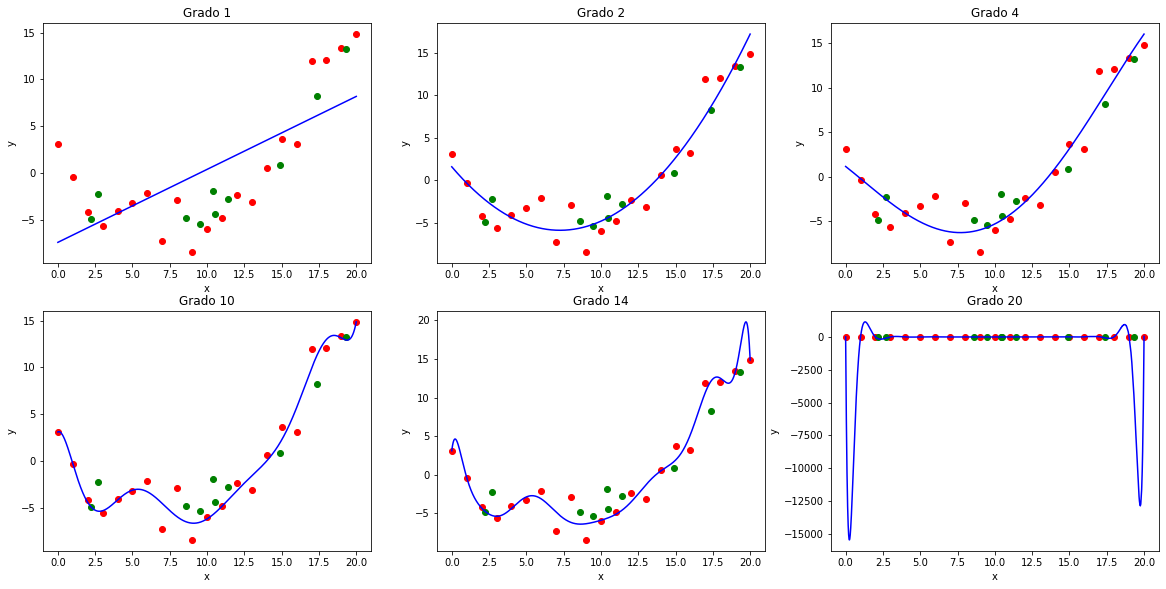

In [11]:
plt.figure(figsize=(20,15))
for i,g in enumerate(grados):
  plt.subplot(3, 3, i + 1)
  y_hat_rango, mse_ent_grados[i], mse_valid_grados[i] = entrena_evalua(MinimosCuadradosQR(), 
                                                                       X_ent, y_ent,
                                                                       X_valid, y_valid,
                                                                       X_rango, g)
  plt.plot(X_ent, y_ent, 'ro', label='Datos de entrenamiento')
  plt.plot(X_valid, y_valid, 'go', label='Datos de validación')
  plt.plot(X_rango, y_hat_rango, 'b', label='Modelo ajustado')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title('Grado ' + str(g))
plt.show()

Revisemos más de cerca el ajuste del modelo para grado 20

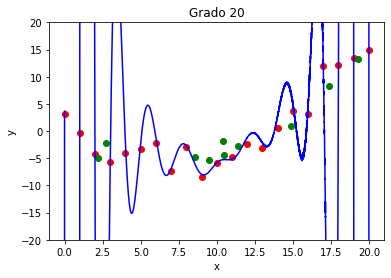

In [12]:
y_hat_rango, mse_ent, mse_valid = entrena_evalua(MinimosCuadradosQR(), 
                                                 X_ent, y_ent,
                                                 X_valid, y_valid,
                                                 X_rango, 20)
plt.plot(X_ent, y_ent, 'ro', label='Datos de entrenamiento')
plt.plot(X_valid, y_valid, 'go', label='Datos de validación')
plt.plot(X_rango, y_hat_rango, 'b', label='Modelo ajustado')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Grado 20')
plt.ylim([-20, 20])
plt.show()

Examinemos los errores cuadráticos medios de entrenamiento y validación para distintos grados de polinomio

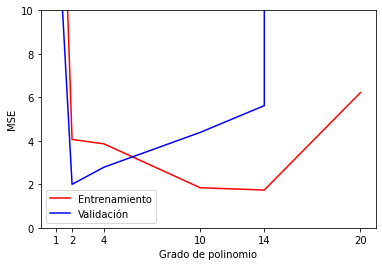

In [13]:
plt.plot(grados, mse_ent_grados, 'r', label='Entrenamiento')
plt.plot(grados, mse_valid_grados, 'b', label='Validación')
plt.xlabel('Grado de polinomio')
plt.ylabel('MSE')
plt.ylim([0, 10])
plt.xticks(grados, grados)
plt.legend()
plt.show()

### Por descomposición SVD
De forma alternativa, podemos opbtener la solución de mínimos cuadrados por medio de la descomposición SVD como sigue:

\begin{align*}
\boldsymbol{\theta}_{EMV} & = \mathbf{V}^\top \mathbf{D}^{-1} \mathbf{U}^\top \mathbf{y}\\
\mathbf{X} & = \mathbf{U} \mathbf{D} \mathbf{V}^\top
\end{align*}

## Penalización por norma $\ell_2$
Se puede ver que después del grado 2 los modelos se sobreajustan. Probemos entrenar un modelo de regresión lineal con penalización por norma $\ell_2$. La solución cerrada está dada por  
$$
\boldsymbol{\theta}_{MAP} = (\lambda \mathbf{I} + \mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y}
$$

Generamos una nueva clase hija de `RegresionLineal` donde se define el método (`_estima_parametros`) con esta solución.


In [14]:
class MinimosCuadradosL2(RegresionLineal):
  def __init__(self, lc = 0.01):
    self._lc = lc

  def _estima_parametros(self, X, y):
    lcI = self._lc * np.identity(X.shape[1])
    self.parameters = np.linalg.inv(lcI + X.T @ X) @ X.T @ y

Entrenamos y evaluamos el método de regresión lineal con penalización por norma $\ell_2$ usando distintos valores para $\lambda$.

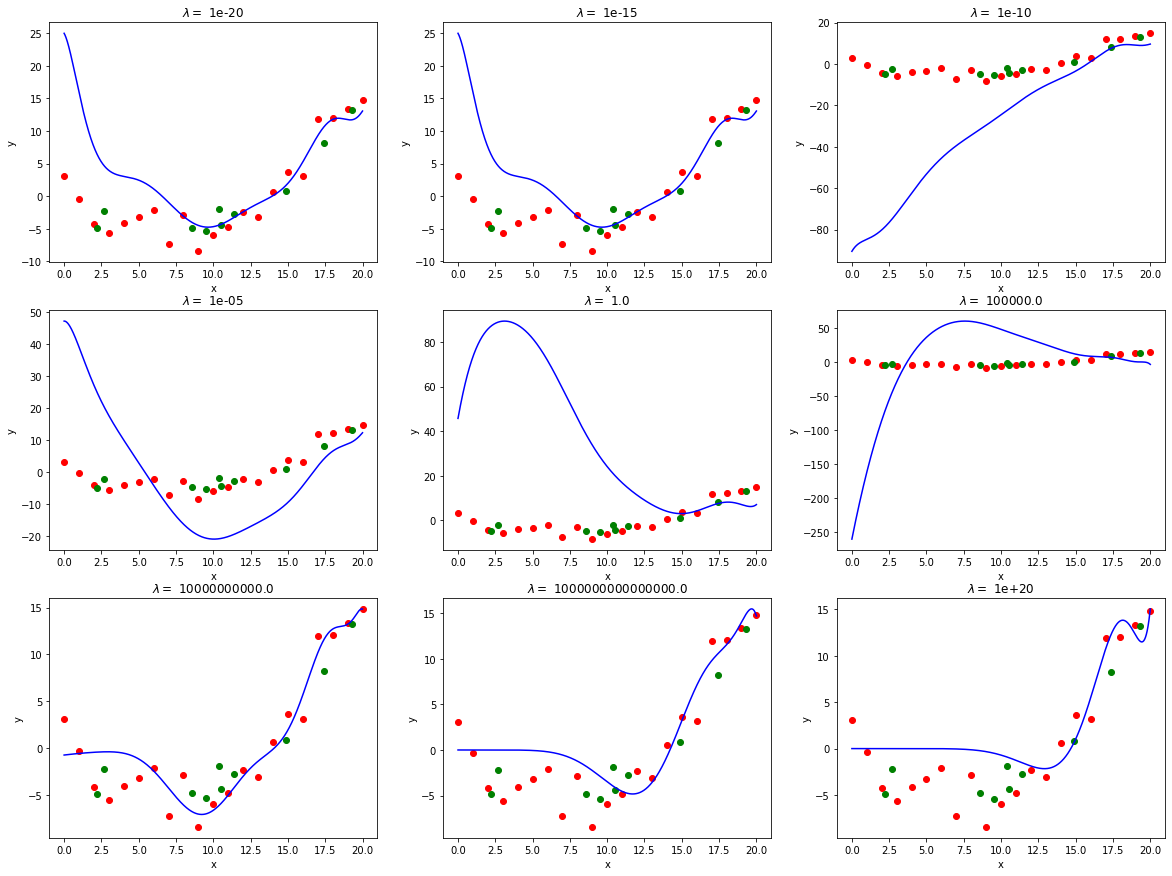

In [15]:
plt.figure(figsize=(20,15))
lambdas = np.geomspace(1e-20, 1e20, num=9)
mse_ent_lambdas = np.zeros(lambdas.shape[0])
mse_valid_lambas = np.zeros(lambdas.shape[0])
for i,l in enumerate(lambdas):
  plt.subplot(3, 3, i + 1)
  y_hat_rango, mse_ent_lambdas[i], mse_valid_lambas[i] = entrena_evalua(MinimosCuadradosL2(lc=l), 
                                                                        X_ent, y_ent,
                                                                        X_valid, y_valid,
                                                                        X_rango, 14)
  plt.plot(X_ent, y_ent, 'ro', label='Datos de entrenamiento')
  plt.plot(X_valid, y_valid, 'go', label='Datos de validación')
  plt.plot(X_rango, y_hat_rango, 'b', label='Modelo ajustado')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title('$\lambda = $ ' + str(l))
plt.show()

### Por descomposición QR
Esta solución es numéricamente inestable. Podemos usar nuevamente la descomposición QR

$$
\boldsymbol{\theta}_{MAP} = \mathbf{R}^{-1} \mathbf{Q}^\top \mathbf{\widetilde{y}}
$$

donde

$$
\begin{align}
\mathbf{\widetilde{X}} & = \begin{pmatrix} 
\mathbf{X} \\
\sqrt{\lambda} \mathbf{I}_d
\end{pmatrix} = \mathbf{Q} \mathbf{R}\\ 
\mathbf{\widetilde{y}} & = \begin{pmatrix} 
\mathbf{y} \\
\mathbf{0}_{d}
\end{pmatrix}
\end{align} 
$$

Creamos una clase hija con esta solución

In [16]:
class MinimosCuadradosL2QR(RegresionLineal):
  def __init__(self, lc = 0.01):
    self._lc = lc

  def _estima_parametros(self, X, y):
    lcI = np.sqrt(self._lc * np.identity(X.shape[1]))
    X_tilde = np.concatenate((X, lcI))
    y_tilde = np.concatenate((y, np.zeros(X.shape[1])))
    q, r = np.linalg.qr(X_tilde)
    self.parameters = np.linalg.inv(r) @ q.T @ y_tilde

Repetimos el proceso anterior

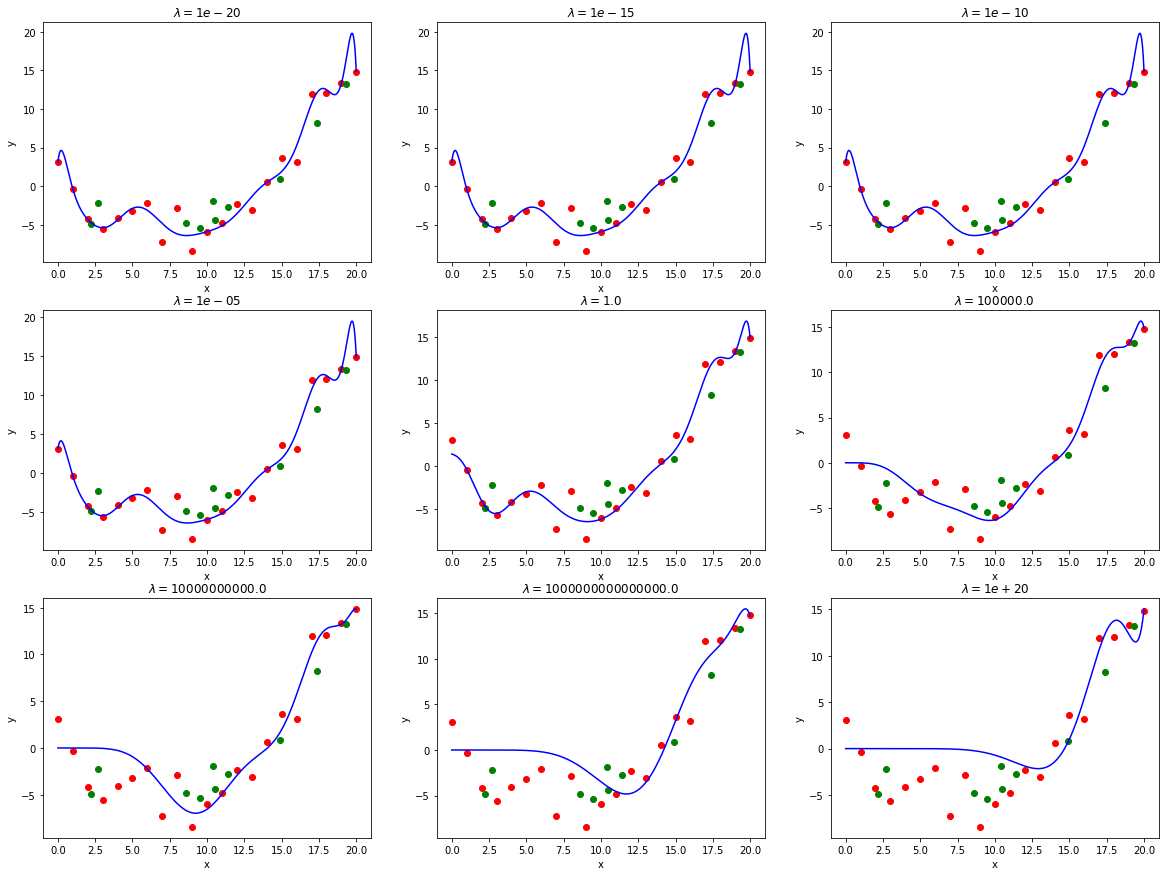

In [17]:
plt.figure(figsize=(20,15))
for i,l in enumerate(lambdas):
  plt.subplot(3, 3, i + 1)
  y_hat_rango, mse_ent_lambdas[i], mse_valid_lambas[i] = entrena_evalua(MinimosCuadradosL2QR(lc=l), 
                                                                        X_ent, y_ent,
                                                                        X_valid, y_valid,
                                                                        X_rango, 14)
  plt.plot(X_ent, y_ent, 'ro', label='Datos de entrenamiento')
  plt.plot(X_valid, y_valid, 'go', label='Datos de validación')
  plt.plot(X_rango, y_hat_rango, 'b', label='Modelo ajustado')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title('$\lambda = ' + str(l) + '$')
plt.show()

Graficamos los errores cuadráticos medios de entrenamiento y validación para distintos valores de $\lambda$

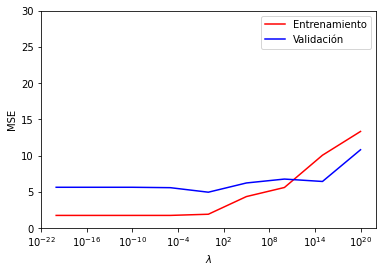

In [18]:
plt.plot(lambdas, mse_ent_lambdas, 'r', label='Entrenamiento')
plt.plot(lambdas, mse_valid_lambas, 'b', label='Validación')
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('MSE')
plt.ylim([0, 30])
plt.legend()
plt.show()

### Por descomposición SVD
De la misma manera, la solución de mínimos cuadrados con penalización por norma $\ell_2$ se puede llevar a cabo por medio de la descomposición SVD:

\begin{align*}
\boldsymbol{\theta}_{EMV} & = \mathbf{V} \left(\mathbf{D}^2 + \lambda \mathbf{I}\right)^{-1} \mathbf{D}\mathbf{U}^\top \mathbf{y}\\
\mathbf{X} & = \mathbf{U} \mathbf{D} \mathbf{V}^\top
\end{align*}

## Penalización $\ell_1$
Si penalizamos los parámetros por norma $\ell_1$ obtenemos LASSO (_least absolute shrinkage and selection operator_). Probemos con LASSO usando diferentes valores de $\lambda$

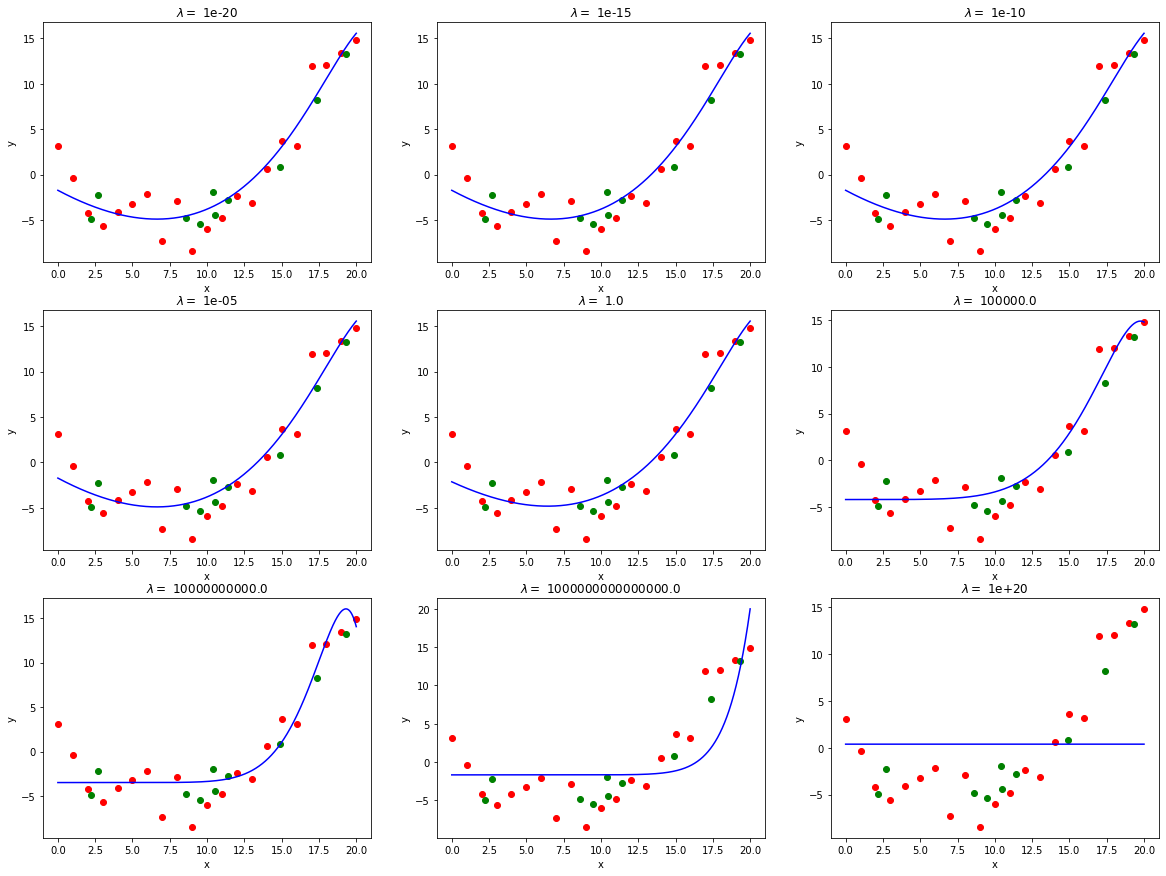

In [19]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(20,15))
for i,l in enumerate(lambdas):
  plt.subplot(3, 3, i + 1)
  y_hat_rango, mse_ent_lambdas[i], mse_valid_lambas[i] = entrena_evalua(Lasso(alpha=l, tol=0.08), 
                                                                        X_ent, y_ent,
                                                                        X_valid, y_valid,
                                                                        X_rango, 14)
  plt.plot(X_ent, y_ent, 'ro', label='Datos de entrenamiento')
  plt.plot(X_valid, y_valid, 'go', label='Datos de validación')
  plt.plot(X_rango, y_hat_rango, 'b', label='Modelo ajustado')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title('$\lambda = $ ' + str(l))
plt.show()

Examinamos los errores de entrenamiento y validación

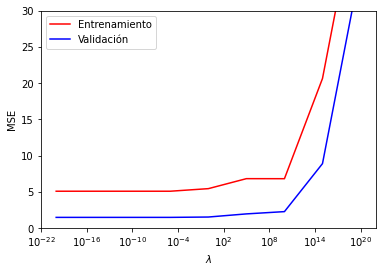

In [20]:
plt.plot(lambdas, mse_ent_lambdas, 'r', label='Entrenamiento')
plt.plot(lambdas, mse_valid_lambas, 'b', label='Validación')
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('MSE')
plt.ylim([0, 30])
plt.legend()
plt.show()